In [26]:
import torch.nn as nn
class LatentMLP(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super(LatentMLP, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(latent_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.lr = nn.LeakyReLU()
        
    def forward(self, z, baseline_bdi):
        out = torch.cat([z, baseline_bdi], dim=1)

        out = self.fc1(out)
        out = self.lr(out)
        out = self.fc2(out)
        return out


In [31]:
from utils import VAE, BrainGraphDataset
import torch
import torch.optim as optim
import os

# instantiate the VGAE model
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100
output_dim = 1
lr = 0.001
batch_size = 8

model = VAE(input_dim, hidden_dim, latent_dim)

# load the trained VGAE weights
model.load_state_dict(torch.load('vae_weights/gmm_3_hidden256_latent64.pt'))

# freeze the weights of the VGAE
for param in model.parameters():
    param.requires_grad = False

# instantiate the LatentMLP model
mlp = LatentMLP(latent_dim, hidden_dim, output_dim)

# define the optimizer and the loss function
optimizer = optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.L1Loss(reduction='sum')

dataroot = 'fc_matrices/psilo_ica_100_after'
cwd = os.getcwd() + '/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert the model to the device
model.to(device)

# Convert the MLP to the device
mlp.to(device)

annotations = 'annotations.csv'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='graph_and_baseline')

# Define the train, validation, and test ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Get the number of samples in the dataset
num_samples = len(psilo_dataset)

# Calculate the number of samples for each set
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(psilo_dataset, [train_size, val_size, test_size])

# Define the dataloaders for each set

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=val_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_size, shuffle=False)

num_epochs = 200

best_val_loss = float('inf')
best_model_state = None

# train the MLP on the new dataset
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        (graphs, base_bdis), labels = data
        
        graphs = graphs.to(device)
        base_bdis = base_bdis.to(device)
        
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the latent embeddings from the VGAE
        _, _, _, zs = model(graphs.view(-1, input_dim))
         
        # pass the latent embeddings through the MLP
        
        outputs = mlp(zs, base_bdis)

        # calculate the loss and backpropagate
        loss = criterion(outputs, labels.view(outputs.shape))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    # Validation check
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            (graphs, base_bdis), labels = data

            graphs = graphs.to(device)
            base_bdis = base_bdis.to(device)

            labels = labels.to(device).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # get the latent embeddings from the VGAE
            _, _, _, zs = model(graphs.view(-1, input_dim))

            # pass the latent embeddings through the MLP
            outputs = mlp(zs, base_bdis)
            val_loss += criterion(outputs, labels.view(outputs.shape)).item()
    val_loss /= len(val_set)
    
    # Save the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = mlp.state_dict()
    
    # Print statistics and perform testing every 5 epochs
    if epoch % 10 == 9:
        print('[%d, %5d] loss: %.3f, val_loss: %.3f' %
              (epoch + 1, i + 1, running_loss / (len(train_set)), val_loss))
        running_loss = 0.0

print('Finished training') 

[10,     4] loss: 7.764, val_loss: 6.863
[20,     4] loss: 6.934, val_loss: 6.953
[30,     4] loss: 6.152, val_loss: 7.235
[40,     4] loss: 5.270, val_loss: 7.393
[50,     4] loss: 4.475, val_loss: 7.530
[60,     4] loss: 3.783, val_loss: 7.592
[70,     4] loss: 3.101, val_loss: 7.828
[80,     4] loss: 2.819, val_loss: 7.633
[90,     4] loss: 2.158, val_loss: 7.278
[100,     4] loss: 1.652, val_loss: 7.605
[110,     4] loss: 1.377, val_loss: 7.846
[120,     4] loss: 1.075, val_loss: 7.281
[130,     4] loss: 1.061, val_loss: 7.184
[140,     4] loss: 0.933, val_loss: 7.179
[150,     4] loss: 0.761, val_loss: 6.852
[160,     4] loss: 0.877, val_loss: 6.936
[170,     4] loss: 0.781, val_loss: 6.444
[180,     4] loss: 0.552, val_loss: 7.110
[190,     4] loss: 0.634, val_loss: 7.465
[200,     4] loss: 0.635, val_loss: 7.081
Finished training


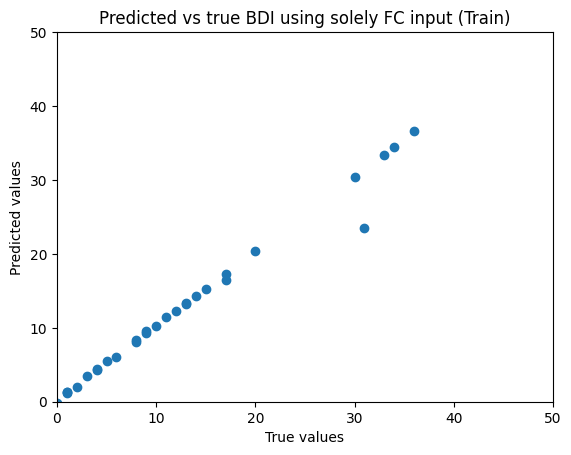

Train loss: 0.564


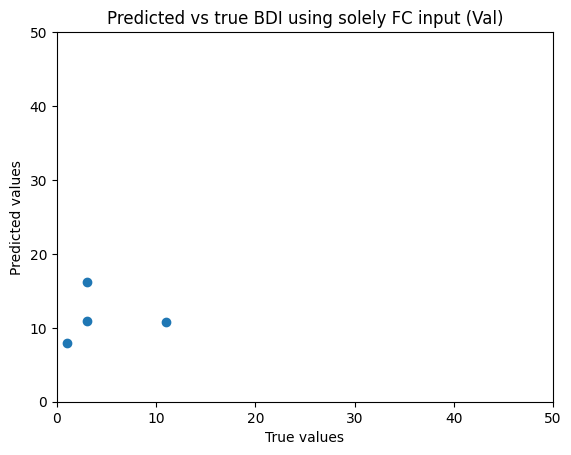

Val loss: 7.233


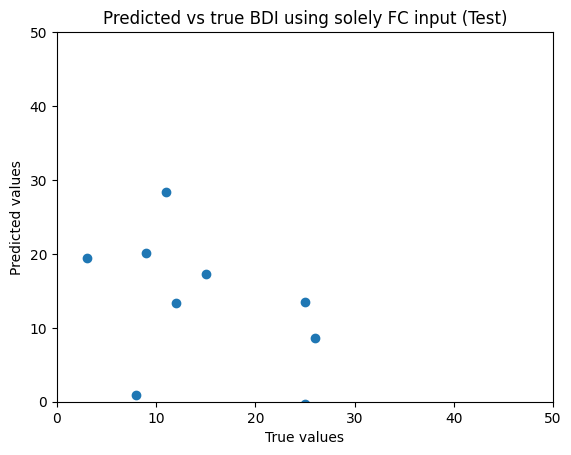

Test loss: 13.020


In [33]:
# Load the best model and perform final testing
mlp.load_state_dict(best_model_state)
test_loss = 0.0

import matplotlib.pyplot as plt

# Evaluate the model on the test set and plot the results

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_size, shuffle=True)

names = ['Train', 'Val', 'Test']
datasets = [train_set, val_set, test_set]
loaders = [train_loader, val_loader, test_loader]

for i in range(3):
    with torch.no_grad():
        for data in loaders[i]:
            (graphs, base_bdis), labels = data

            graphs = graphs.to(device)
            base_bdis = base_bdis.to(device)

            labels = labels.to(device).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # get the latent embeddings from the VGAE
            _, _, _, zs = model(graphs.view(-1, input_dim))

            # pass the latent embeddings through the MLP

            outputs = mlp(zs, base_bdis)
            criterion = nn.L1Loss(reduction='sum')
            test_loss += criterion(outputs, labels.view(outputs.shape)).item()

            # Convert back to CPU and numpy arrays for plotting
            labels = labels.cpu().numpy().reshape(-1)
            predictions = outputs.cpu().numpy().reshape(-1)

            # Plot the results
            plt.scatter(labels, predictions)
            plt.xlabel('True values')
            plt.ylabel('Predicted values')
            plt.title(f'Predicted vs true BDI using solely FC input ({names[i]})')
            plt.xlim([0,50])
            plt.ylim([0,50])
            plt.show()

    # Print the test loss
    test_loss /= len(datasets[i])
    print(f'{names[i]} loss: %.3f' % test_loss)